# 1. Import

In [2]:
# Basic Library
import os
import pandas as pd
import numpy as np
import pickle
from itertools import permutations, combinations
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer

# HP Tuning
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour, plot_optimization_history
from optuna.visualization import plot_parallel_coordinate, plot_slice, plot_param_importances

# Modeling
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
import xgboost as xgb
from catboost import CatBoostRegressor, Pool

In [3]:
def create_dir(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)
        print("Created Directory :", dir)
    else:
        print("Directory already existed :", dir)
create_dir("../pickle")
create_dir("../model")
create_dir("../submission")

Directory already existed : ../pickle
Directory already existed : ../model
Directory already existed : ../submission


In [4]:
train = pd.read_csv("../data/train_f1.csv")
test = pd.read_csv("../data/test_f1.csv")
submission = pd.read_csv("../data/sample_submission.csv")

In [5]:
rows_train = train.shape[0] # 주어진 train data의 row 수
rows_test = test.shape[0] # 주어진 test data의 row 수
num_trial = 100 # 파라미터 튜닝을 몇 번 진행하는지의 수
splits_hp = 5 # 파라미터 튜닝을 진행할 때의 kfold 수
splits_tr = 15 # 모델 트레이닝을 진행할 때의 kfold 수
basic_seed = 42 # default seed
num_seed_hp = 3 # 파라미터 튜닝 seed 개수
num_seed_tr = 10 # 트레이닝 seed 개수
sel_seed = 3 # 선택할 seed 개수

In [6]:
pred_dict = {}
pred_test_dict = {}

# 2. Catboost

In [7]:
train_lab = train.copy()
test_lab = test.copy()

for col in train_lab.columns:
    if train_lab[col].dtypes=='object':
        train_lab[col] = train_lab[col].astype('category')
        test_lab[col] = test_lab[col].astype('category')

train_x = train_lab.drop(['Target'], axis=1) # 데이터 나누기
train_y = train_lab['Target']
test_x = test_lab.copy()

print('Category Encoding Completed')

Category Encoding Completed


In [8]:
train_lab = train.copy()
test_lab = test.copy()

train_x = train_lab.drop(['Target'], axis=1) # 데이터 나누기
train_y = train_lab['Target']
test_x = test_lab.copy()

In [73]:
cat_features = ["Gender"]

In [74]:
def cat_objective(trial: Trial) -> float:
    score_hp = []
    for seed_hp in np.random.randint(0, 1000, 2):
        params_cat = {
            "cat_features": cat_features,
            "random_state": seed_hp,
            "loss_function": "MAE",
            "eval_metric": "MAE",
            "iterations": 10000,
            "od_type": "iter",
            "od_wait": trial.suggest_int("od_wait", 30, 500),
            "learning_rate": trial.suggest_uniform("learning_rate", 1e-2, 1e-1), # default=0.03, range=[0,1]
            "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0),
            "bagging_temperature" :trial.suggest_loguniform('bagging_temperature', 1e-2, 1e+2),
            "random_strength" :trial.suggest_int('random_strength', 0, 100),
            "depth": trial.suggest_int("depth", 4, 8),
            "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-5, 1e+2), # default=3, range=[0,1]
#             "random_strength": trial.suggest_loguniform("random_strength", 1e-1, 1e+1),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 50),
            "max_bin": trial.suggest_int("max_bin", 200, 500),
            "od_type": trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        }

        kfold = StratifiedKFold(n_splits=splits_hp, random_state=seed_hp, shuffle=True) # Cross-validation cv=5
        cv = np.zeros(rows_train)

        for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):

            x_train, x_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
            y_train, y_val = train_y.iloc[train_idx].values, train_y.iloc[val_idx].values

            catmodel = CatBoostRegressor(**params_cat)
                                                                                            # 진행상황 보고싶을때 -1을 100으로
            catmodel.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=50, verbose=200) 
            cv[val_idx] = catmodel.predict(x_val)
            
        score_hp.append(mean_absolute_error(train_y, cv))
    
    np.mean(score_hp)
    return np.mean(score_hp)

In [ ]:
sampler = TPESampler(seed=basic_seed)
cat_study = optuna.create_study(study_name="cat_parameter_opt", direction="minimize", sampler=sampler)
cat_study.optimize(cat_objective, n_trials=num_trial)

cat_best_hyperparams = cat_study.best_trial.params
cat_base_hyperparams = {'loss_function': 'MAE', 'eval_metric': 'MAE', 'cat_features': cat_features, 'random_state': basic_seed,
                        'od_type': 'iter', 'iterations':10000}
cat_best_hyperparams.update(cat_base_hyperparams)

with open('../pickle/cat_best_hyperparams.pickle', 'wb') as fw:
    pickle.dump(cat_best_hyperparams, fw)
print("The best hyperparameters are:\n", cat_best_hyperparams)

In [75]:
sampler = TPESampler(seed=basic_seed)
cat_study = optuna.create_study(study_name="cat_parameter_opt", direction="minimize", sampler=sampler)
cat_study.optimize(cat_objective, n_trials=num_trial)

cat_best_hyperparams = cat_study.best_trial.params
cat_base_hyperparams = {'loss_function': 'MAE', 'eval_metric': 'MAE', 'cat_features': cat_features, 'random_state': basic_seed,
                        'od_type': 'iter', 'iterations':10000}
cat_best_hyperparams.update(cat_base_hyperparams)

with open('../pickle/cat_best_hyperparams.pickle', 'wb') as fw:
    pickle.dump(cat_best_hyperparams, fw)
print("The best hyperparameters are:\n", cat_best_hyperparams)

[I 2022-03-27 22:29:04,672] A new study created in memory with name: cat_parameter_opt
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 2.2698746	test: 2.2812756	best: 2.2812756 (0)	total: 234ms	remaining: 38m 56s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.413395059
bestIteration = 112

Shrink model to first 113 iterations.
0:	learn: 2.2795516	test: 2.2864291	best: 2.2864291 (0)	total: 241ms	remaining: 40m 13s
200:	learn: 1.0934744	test: 1.3671170	best: 1.3644023 (153)	total: 56.2s	remaining: 45m 40s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.364402322
bestIteration = 153

Shrink model to first 154 iterations.
0:	learn: 2.2564544	test: 2.3292884	best: 2.3292884 (0)	total: 254ms	remaining: 42m 19s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.496321288
bestIteration = 120

Shrink model to first 121 iterations.
0:	learn: 2.2774659	test: 2.2345781	best: 2.2345781 (0)	total: 243ms	remaining: 40m 26s
200:	learn: 1.0837928	test: 1.5031511	best: 1.5011278 (192)	total: 55.2s	remaining: 44m 53s
Stopped by overfitting detector  (50 iterations wait)

[I 2022-03-27 22:37:40,062] Trial 0 finished with value: 1.4582842361162232 and parameters: {'od_wait': 206, 'learning_rate': 0.09556428757689246, 'colsample_bylevel': 0.839196365086843, 'bagging_temperature': 2.481040974867813, 'random_strength': 15, 'depth': 4, 'l2_leaf_reg': 2.550264850403285e-05, 'min_data_in_leaf': 44, 'max_bin': 380, 'od_type': 'IncToDec'}. Best is trial 0 with value: 1.4582842361162232.


0:	learn: 2.2810209	test: 2.2946211	best: 2.2946211 (0)	total: 224ms	remaining: 37m 15s
200:	learn: 1.0057694	test: 1.5202679	best: 1.5051525 (159)	total: 56.7s	remaining: 46m 4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.505152489
bestIteration = 159

Shrink model to first 160 iterations.
0:	learn: 2.2818494	test: 2.2852238	best: 2.2852238 (0)	total: 225ms	remaining: 37m 30s
200:	learn: 0.9948416	test: 1.4109173	best: 1.4063008 (163)	total: 57s	remaining: 46m 20s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.406300755
bestIteration = 163

Shrink model to first 164 iterations.
0:	learn: 2.2639686	test: 2.3377691	best: 2.3377691 (0)	total: 224ms	remaining: 37m 22s
200:	learn: 0.9924864	test: 1.5229401	best: 1.5104646 (163)	total: 56.7s	remaining: 46m 5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.510464564
bestIteration = 163

Shrink model to first 164 iterations.
0:	learn: 2.2908888	test: 2.2565550	best: 2.2565550 (

[I 2022-03-27 22:46:56,474] Trial 1 finished with value: 1.4619243542416687 and parameters: {'od_wait': 486, 'learning_rate': 0.08491983767203796, 'colsample_bylevel': 0.5274034664069657, 'bagging_temperature': 0.053370327626039576, 'random_strength': 18, 'depth': 5, 'l2_leaf_reg': 0.047129737561107825, 'min_data_in_leaf': 22, 'max_bin': 287, 'od_type': 'IncToDec'}. Best is trial 0 with value: 1.4582842361162232.


0:	learn: 2.3119191	test: 2.3173041	best: 2.3173041 (0)	total: 556ms	remaining: 1h 32m 41s
200:	learn: 1.2676325	test: 1.4142159	best: 1.4112188 (193)	total: 2m 17s	remaining: 1h 51m 26s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.386421101
bestIteration = 343

Shrink model to first 344 iterations.
0:	learn: 2.3087142	test: 2.3244484	best: 2.3244484 (0)	total: 554ms	remaining: 1h 32m 21s
200:	learn: 1.2377234	test: 1.5301152	best: 1.5301152 (200)	total: 2m 16s	remaining: 1h 50m 33s
400:	learn: 0.8761383	test: 1.4855960	best: 1.4839901 (392)	total: 4m 33s	remaining: 1h 48m 58s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.483990115
bestIteration = 392

Shrink model to first 393 iterations.
0:	learn: 2.3030345	test: 2.3714012	best: 2.3714012 (0)	total: 547ms	remaining: 1h 31m 12s
200:	learn: 1.2445950	test: 1.5357277	best: 1.5353483 (199)	total: 2m 19s	remaining: 1h 53m
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.50298

[I 2022-03-27 23:24:36,248] Trial 2 finished with value: 1.4598500631110762 and parameters: {'od_wait': 167, 'learning_rate': 0.04297256589643226, 'colsample_bylevel': 0.6736419905302216, 'bagging_temperature': 13.826232179369875, 'random_strength': 20, 'depth': 6, 'l2_leaf_reg': 0.14024971326600363, 'min_data_in_leaf': 3, 'max_bin': 382, 'od_type': 'IncToDec'}. Best is trial 0 with value: 1.4582842361162232.


0:	learn: 2.2500805	test: 2.2670629	best: 2.2670629 (0)	total: 1.17s	remaining: 3h 14m 16s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.454869701
bestIteration = 114

Shrink model to first 115 iterations.
0:	learn: 2.2532062	test: 2.2719588	best: 2.2719588 (0)	total: 1.16s	remaining: 3h 14m 7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.462832371
bestIteration = 46

Shrink model to first 47 iterations.
0:	learn: 2.2436439	test: 2.3147485	best: 2.3147485 (0)	total: 1.17s	remaining: 3h 14m 15s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.643028881
bestIteration = 109

Shrink model to first 110 iterations.
0:	learn: 2.2746105	test: 2.2229683	best: 2.2229683 (0)	total: 1.14s	remaining: 3h 10m 42s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.44198955
bestIteration = 81

Shrink model to first 82 iterations.
0:	learn: 2.2773239	test: 2.2562878	best: 2.2562878 (0)	total: 1.2s	remaining: 3h 20m 47s
Stop

[I 2022-03-27 23:57:27,037] Trial 3 finished with value: 1.4758450635579954 and parameters: {'od_wait': 476, 'learning_rate': 0.09690688297671035, 'colsample_bylevel': 0.8850384088698766, 'bagging_temperature': 0.1653693718282443, 'random_strength': 9, 'depth': 7, 'l2_leaf_reg': 0.012052231254145614, 'min_data_in_leaf': 7, 'max_bin': 349, 'od_type': 'Iter'}. Best is trial 0 with value: 1.4582842361162232.


0:	learn: 2.2955740	test: 2.3097425	best: 2.3097425 (0)	total: 228ms	remaining: 38m 4s
200:	learn: 1.2469318	test: 1.3600884	best: 1.3600884 (200)	total: 52.5s	remaining: 42m 40s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.354644917
bestIteration = 241

Shrink model to first 242 iterations.
0:	learn: 2.2979617	test: 2.3063132	best: 2.3063132 (0)	total: 207ms	remaining: 34m 27s
200:	learn: 1.2611261	test: 1.3537794	best: 1.3480704 (193)	total: 53.5s	remaining: 43m 28s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.348070427
bestIteration = 193

Shrink model to first 194 iterations.
0:	learn: 2.2849494	test: 2.3471871	best: 2.3471871 (0)	total: 208ms	remaining: 34m 41s
200:	learn: 1.2157175	test: 1.5416898	best: 1.5416898 (200)	total: 53.6s	remaining: 43m 34s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.541586761
bestIteration = 207

Shrink model to first 208 iterations.
0:	learn: 2.3041004	test: 2.2739441	best: 2.273944

[I 2022-03-28 00:08:58,075] Trial 4 finished with value: 1.4536308579758277 and parameters: {'od_wait': 151, 'learning_rate': 0.06962700559185839, 'colsample_bylevel': 0.5870266456536466, 'bagging_temperature': 1.2030178871154673, 'random_strength': 55, 'depth': 4, 'l2_leaf_reg': 61.24806805925977, 'min_data_in_leaf': 39, 'max_bin': 482, 'od_type': 'IncToDec'}. Best is trial 4 with value: 1.4536308579758277.


0:	learn: 2.3319814	test: 2.3471132	best: 2.3471132 (0)	total: 223ms	remaining: 37m 14s
200:	learn: 1.5257768	test: 1.5384581	best: 1.5384581 (200)	total: 58.8s	remaining: 47m 45s
400:	learn: 1.3799018	test: 1.4387641	best: 1.4387641 (400)	total: 1m 57s	remaining: 46m 46s
600:	learn: 1.2596933	test: 1.3936659	best: 1.3936659 (600)	total: 2m 56s	remaining: 45m 58s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.390277905
bestIteration = 629

Shrink model to first 630 iterations.
0:	learn: 2.3322444	test: 2.3424134	best: 2.3424134 (0)	total: 231ms	remaining: 38m 34s
200:	learn: 1.5140585	test: 1.5634709	best: 1.5634709 (200)	total: 1m	remaining: 49m 21s
400:	learn: 1.3682694	test: 1.4925941	best: 1.4925941 (400)	total: 1m 59s	remaining: 47m 50s
600:	learn: 1.2383376	test: 1.4737211	best: 1.4737211 (600)	total: 2m 58s	remaining: 46m 36s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.469788792
bestIteration = 628

Shrink model to first 629 iteration

[I 2022-03-28 00:49:15,211] Trial 5 finished with value: 1.4506757249031441 and parameters: {'od_wait': 464, 'learning_rate': 0.017964325184672756, 'colsample_bylevel': 0.5175897174514872, 'bagging_temperature': 0.015167330688076212, 'random_strength': 32, 'depth': 5, 'l2_leaf_reg': 0.0007933105363733019, 'min_data_in_leaf': 42, 'max_bin': 307, 'od_type': 'Iter'}. Best is trial 5 with value: 1.4506757249031441.


0:	learn: 2.2926975	test: 2.3068226	best: 2.3068226 (0)	total: 175ms	remaining: 29m 9s
200:	learn: 1.1468406	test: 1.5272232	best: 1.5224278 (152)	total: 39.2s	remaining: 31m 51s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.522427849
bestIteration = 152

Shrink model to first 153 iterations.
0:	learn: 2.2952541	test: 2.3051309	best: 2.3051309 (0)	total: 171ms	remaining: 28m 32s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.502441069
bestIteration = 138

Shrink model to first 139 iterations.
0:	learn: 2.2810219	test: 2.3522847	best: 2.3522847 (0)	total: 181ms	remaining: 30m 11s
200:	learn: 1.1257671	test: 1.5523839	best: 1.5437103 (164)	total: 40.5s	remaining: 32m 56s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.543710291
bestIteration = 164

Shrink model to first 165 iterations.
0:	learn: 2.3172634	test: 2.2699681	best: 2.2699681 (0)	total: 166ms	remaining: 27m 40s
200:	learn: 1.2044571	test: 1.3543108	best: 1.3440775 

[I 2022-03-28 00:57:00,191] Trial 6 finished with value: 1.4602943546141625 and parameters: {'od_wait': 96, 'learning_rate': 0.08219772826786358, 'colsample_bylevel': 0.44473038620786254, 'bagging_temperature': 88.62326508576255, 'random_strength': 77, 'depth': 4, 'l2_leaf_reg': 1.093087227940451e-05, 'min_data_in_leaf': 41, 'max_bin': 412, 'od_type': 'Iter'}. Best is trial 5 with value: 1.4506757249031441.


0:	learn: 2.3186806	test: 2.3360025	best: 2.3360025 (0)	total: 208ms	remaining: 34m 37s
200:	learn: 1.3722610	test: 1.4121820	best: 1.4121312 (199)	total: 55.6s	remaining: 45m 10s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.393843085
bestIteration = 235

Shrink model to first 236 iterations.
0:	learn: 2.3207753	test: 2.3278092	best: 2.3278092 (0)	total: 227ms	remaining: 37m 49s
200:	learn: 1.3553174	test: 1.5232360	best: 1.5232360 (200)	total: 56.6s	remaining: 46m 1s
400:	learn: 1.0512985	test: 1.4795269	best: 1.4776324 (392)	total: 1m 52s	remaining: 44m 45s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.47763239
bestIteration = 392

Shrink model to first 393 iterations.
0:	learn: 2.3097687	test: 2.3788170	best: 2.3788170 (0)	total: 202ms	remaining: 33m 40s
200:	learn: 1.3355363	test: 1.5773002	best: 1.5772109 (199)	total: 55.5s	remaining: 45m 7s
400:	learn: 1.0309036	test: 1.5062240	best: 1.5031684 (390)	total: 1m 50s	remaining: 44m 10s
Sto

[I 2022-03-28 01:15:04,494] Trial 7 finished with value: 1.4567563658356377 and parameters: {'od_wait': 64, 'learning_rate': 0.042261915568984544, 'colsample_bylevel': 0.4695214357150779, 'bagging_temperature': 28.34090429514775, 'random_strength': 62, 'depth': 5, 'l2_leaf_reg': 2.7855339243891015e-05, 'min_data_in_leaf': 16, 'max_bin': 297, 'od_type': 'IncToDec'}. Best is trial 5 with value: 1.4506757249031441.


0:	learn: 2.3072125	test: 2.3211249	best: 2.3211249 (0)	total: 441ms	remaining: 1h 13m 28s
200:	learn: 1.2515906	test: 1.3167536	best: 1.3167536 (200)	total: 1m 43s	remaining: 1h 24m 24s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.293008916
bestIteration = 232

Shrink model to first 233 iterations.
0:	learn: 2.3056955	test: 2.3181866	best: 2.3181866 (0)	total: 381ms	remaining: 1h 3m 25s
200:	learn: 1.1847699	test: 1.5593218	best: 1.5577166 (198)	total: 1m 44s	remaining: 1h 25m 2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.546472568
bestIteration = 233

Shrink model to first 234 iterations.
0:	learn: 2.3015338	test: 2.3666229	best: 2.3666229 (0)	total: 389ms	remaining: 1h 4m 48s
200:	learn: 1.1996593	test: 1.4803220	best: 1.4771510 (184)	total: 1m 43s	remaining: 1h 24m 18s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.47632195
bestIteration = 219

Shrink model to first 220 iterations.
0:	learn: 2.3173574	test: 2.2689

[I 2022-03-28 01:41:14,408] Trial 8 finished with value: 1.4523869300845709 and parameters: {'od_wait': 447, 'learning_rate': 0.05249934326457544, 'colsample_bylevel': 0.471756547562981, 'bagging_temperature': 7.128188058401368, 'random_strength': 76, 'depth': 6, 'l2_leaf_reg': 2.4932754437140145, 'min_data_in_leaf': 25, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 5 with value: 1.4506757249031441.


0:	learn: 2.3315719	test: 2.3477293	best: 2.3477293 (0)	total: 2.79s	remaining: 7h 45m 5s
200:	learn: 1.4570877	test: 1.5047312	best: 1.5047312 (200)	total: 9m 57s	remaining: 8h 5m 30s
400:	learn: 1.2734375	test: 1.4078145	best: 1.4078145 (400)	total: 19m 32s	remaining: 7h 47m 55s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.403091901
bestIteration = 487

Shrink model to first 488 iterations.
0:	learn: 2.3315329	test: 2.3426720	best: 2.3426720 (0)	total: 2.62s	remaining: 7h 16m 1s
200:	learn: 1.4244662	test: 1.6567966	best: 1.6567966 (200)	total: 10m 5s	remaining: 8h 11m 56s
400:	learn: 1.2415930	test: 1.5788476	best: 1.5788476 (400)	total: 19m 57s	remaining: 7h 57m 37s
600:	learn: 1.1339882	test: 1.5582017	best: 1.5581644 (599)	total: 29m 49s	remaining: 7h 46m 28s
800:	learn: 1.0245866	test: 1.5461521	best: 1.5455623 (797)	total: 39m 41s	remaining: 7h 35m 49s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.534267637
bestIteration = 930

Shrin

[I 2022-03-28 08:22:54,856] Trial 9 finished with value: 1.4636905406512635 and parameters: {'od_wait': 80, 'learning_rate': 0.012828626711806084, 'colsample_bylevel': 0.7818462467582683, 'bagging_temperature': 0.1808939009276715, 'random_strength': 51, 'depth': 8, 'l2_leaf_reg': 0.0005559626342779703, 'min_data_in_leaf': 21, 'max_bin': 427, 'od_type': 'IncToDec'}. Best is trial 5 with value: 1.4506757249031441.


0:	learn: 2.3347185	test: 2.3502924	best: 2.3502924 (0)	total: 837ms	remaining: 2h 19m 29s
200:	learn: 1.5432667	test: 1.6494138	best: 1.6494138 (200)	total: 2m 37s	remaining: 2h 8m 21s
400:	learn: 1.3592805	test: 1.5224577	best: 1.5224577 (400)	total: 5m 14s	remaining: 2h 5m 24s
600:	learn: 1.2578238	test: 1.4759794	best: 1.4759794 (600)	total: 7m 50s	remaining: 2h 2m 40s
800:	learn: 1.1859977	test: 1.4544706	best: 1.4544706 (800)	total: 10m 28s	remaining: 2h 15s
1000:	learn: 1.0897211	test: 1.4449950	best: 1.4449058 (997)	total: 13m 7s	remaining: 1h 57m 58s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.441518689
bestIteration = 1052

Shrink model to first 1053 iterations.
0:	learn: 2.3346436	test: 2.3447127	best: 2.3447127 (0)	total: 815ms	remaining: 2h 15m 51s
200:	learn: 1.5677417	test: 1.5686137	best: 1.5686137 (200)	total: 2m 36s	remaining: 2h 7m 31s
400:	learn: 1.3900079	test: 1.4300522	best: 1.4298472 (398)	total: 5m 14s	remaining: 2h 5m 21s
600:	learn: 1.

[I 2022-03-28 11:16:08,046] Trial 10 finished with value: 1.4610331894879889 and parameters: {'od_wait': 342, 'learning_rate': 0.010539746466023542, 'colsample_bylevel': 0.9817222664727197, 'bagging_temperature': 0.011799062523159294, 'random_strength': 33, 'depth': 7, 'l2_leaf_reg': 0.0006389820645489369, 'min_data_in_leaf': 34, 'max_bin': 219, 'od_type': 'Iter'}. Best is trial 5 with value: 1.4506757249031441.


0:	learn: 2.3195276	test: 2.3372250	best: 2.3372250 (0)	total: 536ms	remaining: 1h 29m 20s
200:	learn: 1.3723436	test: 1.4697845	best: 1.4694956 (199)	total: 2m 5s	remaining: 1h 42m
400:	learn: 1.1602322	test: 1.4233376	best: 1.4197018 (392)	total: 4m 8s	remaining: 1h 39m 3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.419158659
bestIteration = 424

Shrink model to first 425 iterations.
0:	learn: 2.3198950	test: 2.3332410	best: 2.3332410 (0)	total: 444ms	remaining: 1h 14m 1s
200:	learn: 1.3390749	test: 1.5590184	best: 1.5575291 (184)	total: 2m	remaining: 1h 38m 16s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.540229086
bestIteration = 327

Shrink model to first 328 iterations.
0:	learn: 2.3097717	test: 2.3790117	best: 2.3790117 (0)	total: 468ms	remaining: 1h 18m 3s
200:	learn: 1.3463844	test: 1.5597012	best: 1.5597012 (200)	total: 2m 4s	remaining: 1h 40m 55s
400:	learn: 1.1512340	test: 1.5247194	best: 1.5246274 (397)	total: 4m 2s	remaining:

[I 2022-03-28 11:55:47,310] Trial 11 finished with value: 1.4745018011155369 and parameters: {'od_wait': 368, 'learning_rate': 0.030091196629865993, 'colsample_bylevel': 0.6135222192046293, 'bagging_temperature': 4.9442122012027765, 'random_strength': 95, 'depth': 6, 'l2_leaf_reg': 6.772363142853468, 'min_data_in_leaf': 50, 'max_bin': 306, 'od_type': 'Iter'}. Best is trial 5 with value: 1.4506757249031441.


0:	learn: 2.3071021	test: 2.3223694	best: 2.3223694 (0)	total: 162ms	remaining: 26m 55s
200:	learn: 1.2763291	test: 1.3932043	best: 1.3932043 (200)	total: 40.1s	remaining: 32m 36s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.368975877
bestIteration = 325

Shrink model to first 326 iterations.
0:	learn: 2.3032798	test: 2.3193017	best: 2.3193017 (0)	total: 146ms	remaining: 24m 20s
200:	learn: 1.2595347	test: 1.5357682	best: 1.5357682 (200)	total: 39.8s	remaining: 32m 20s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.515779921
bestIteration = 250

Shrink model to first 251 iterations.
0:	learn: 2.2987164	test: 2.3700885	best: 2.3700885 (0)	total: 163ms	remaining: 27m 9s
200:	learn: 1.2276469	test: 1.6039907	best: 1.6039907 (200)	total: 40.4s	remaining: 32m 47s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.600401763
bestIteration = 208

Shrink model to first 209 iterations.
0:	learn: 2.3050462	test: 2.2647088	best: 2.264708

[I 2022-03-28 12:06:00,438] Trial 12 finished with value: 1.4686424580159194 and parameters: {'od_wait': 394, 'learning_rate': 0.0575001003727029, 'colsample_bylevel': 0.416272914864736, 'bagging_temperature': 0.3235766254967099, 'random_strength': 77, 'depth': 5, 'l2_leaf_reg': 1.5313462406565799, 'min_data_in_leaf': 33, 'max_bin': 223, 'od_type': 'Iter'}. Best is trial 5 with value: 1.4506757249031441.


0:	learn: 2.3258747	test: 2.3388706	best: 2.3388706 (0)	total: 737ms	remaining: 2h 2m 46s
200:	learn: 1.3394739	test: 1.4380440	best: 1.4378898 (199)	total: 3m 5s	remaining: 2h 30m 43s
400:	learn: 1.1555052	test: 1.3818918	best: 1.3818918 (400)	total: 6m 15s	remaining: 2h 29m 46s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.371212004
bestIteration = 445

Shrink model to first 446 iterations.
0:	learn: 2.3262377	test: 2.3381039	best: 2.3381039 (0)	total: 738ms	remaining: 2h 3m 2s
200:	learn: 1.3122925	test: 1.6004223	best: 1.6001114 (198)	total: 3m 5s	remaining: 2h 31m 2s
400:	learn: 1.1173929	test: 1.5691807	best: 1.5689835 (390)	total: 6m 25s	remaining: 2h 33m 55s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.568361717
bestIteration = 405

Shrink model to first 406 iterations.
0:	learn: 2.3163765	test: 2.3843528	best: 2.3843528 (0)	total: 769ms	remaining: 2h 8m 14s
200:	learn: 1.2976092	test: 1.6286947	best: 1.6286947 (200)	total: 3m 23s	re

[I 2022-03-28 13:28:13,736] Trial 13 finished with value: 1.4560252464349008 and parameters: {'od_wait': 295, 'learning_rate': 0.02447129165391747, 'colsample_bylevel': 0.5348039538809253, 'bagging_temperature': 0.0139113684743087, 'random_strength': 36, 'depth': 7, 'l2_leaf_reg': 0.0020720006754459093, 'min_data_in_leaf': 30, 'max_bin': 339, 'od_type': 'Iter'}. Best is trial 5 with value: 1.4506757249031441.


0:	learn: 2.3136618	test: 2.3277067	best: 2.3277067 (0)	total: 441ms	remaining: 1h 13m 29s
200:	learn: 1.1613504	test: 1.4489776	best: 1.4463115 (197)	total: 1m 51s	remaining: 1h 30m 51s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.431656746
bestIteration = 247

Shrink model to first 248 iterations.
0:	learn: 2.3072183	test: 2.3202683	best: 2.3202683 (0)	total: 425ms	remaining: 1h 10m 47s
200:	learn: 1.1546489	test: 1.4894575	best: 1.4891401 (198)	total: 1m 50s	remaining: 1h 29m 27s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.483179481
bestIteration = 207

Shrink model to first 208 iterations.
0:	learn: 2.3048701	test: 2.3772884	best: 2.3772884 (0)	total: 451ms	remaining: 1h 15m 14s
200:	learn: 1.1294426	test: 1.5993717	best: 1.5933929 (159)	total: 1m 46s	remaining: 1h 26m 51s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.593392945
bestIteration = 159

Shrink model to first 160 iterations.
0:	learn: 2.3086933	test: 2.

[I 2022-03-28 13:54:43,294] Trial 14 finished with value: 1.4658409063470237 and parameters: {'od_wait': 420, 'learning_rate': 0.05780116273163144, 'colsample_bylevel': 0.6911861177184772, 'bagging_temperature': 9.46758146812573, 'random_strength': 71, 'depth': 6, 'l2_leaf_reg': 0.42893501710241, 'min_data_in_leaf': 15, 'max_bin': 258, 'od_type': 'IncToDec'}. Best is trial 5 with value: 1.4506757249031441.


0:	learn: 2.3182886	test: 2.3352658	best: 2.3352658 (0)	total: 244ms	remaining: 40m 41s
200:	learn: 1.3871463	test: 1.5209654	best: 1.5188808 (187)	total: 1m 4s	remaining: 52m 41s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.482743402
bestIteration = 313

Shrink model to first 314 iterations.
0:	learn: 2.3190577	test: 2.3300636	best: 2.3300636 (0)	total: 241ms	remaining: 40m 5s


KeyboardInterrupt: 

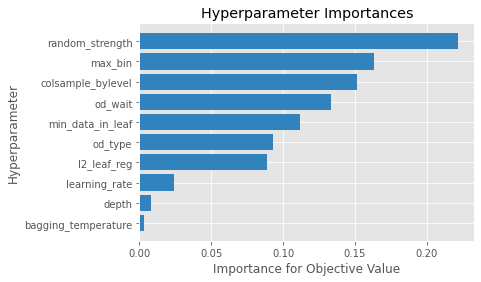

In [76]:
optuna.visualization.matplotlib.plot_param_importances(cat_study);

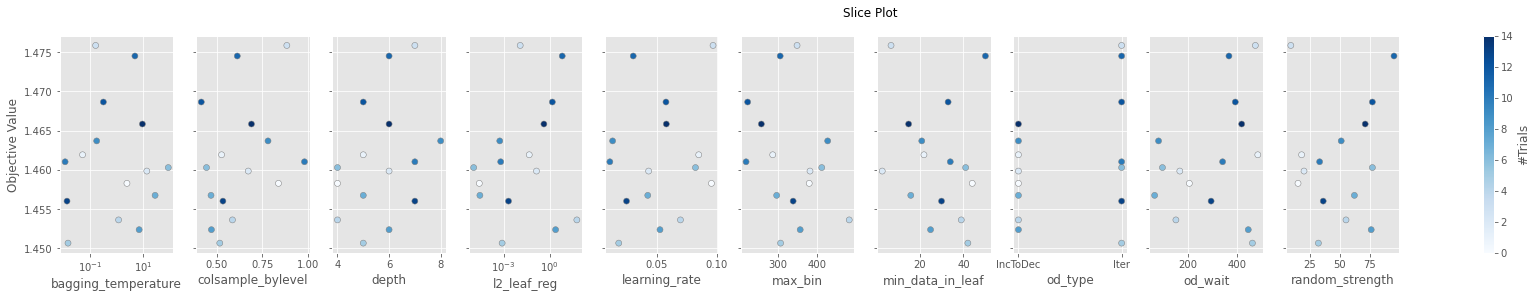

In [77]:
optuna.visualization.matplotlib.plot_slice(cat_study);

In [ ]:
# with open('../pickle/cat_best_hyperparams.pickle', 'rb') as fw:
#     cat_best_hyperparams = pickle.load(fw)

In [ ]:
lucky_seeds = np.random.randint(0, 1000, num_seed_tr)

for i, seed in enumerate(lucky_seeds):

    kfold = StratifiedKFold(n_splits=splits_tr, random_state=seed, shuffle=True) # CV 늘려가면서 하기
    cv = np.zeros(rows_train)
    pred_test = np.zeros(rows_test)

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):
        
        x_train, x_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
        y_train, y_val = train_y.iloc[train_idx].values.ravel(), train_y.iloc[val_idx].values.ravel()

        catmodel = CatBoostRegressor(**cat_best_hyperparams)
        catmodel.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=30, verbose=200)
        
        cv[val_idx] = catmodel.predict(x_val)
        pred_test += catmodel.predict(test_x) / splits_tr
        
    pred_dict['cat'+str(seed)] = cv
    pred_test_dict['cat'+str(seed)] = pred_test
    print(f'seed {seed}', 'mean_absolute_error :', mean_absolute_error(train_y, cv))

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 2.3404095	test: 2.3020375	best: 2.3020375 (0)	total: 192ms	remaining: 31m 55s
200:	learn: 1.4935354	test: 1.6818427	best: 1.6818427 (200)	total: 59.8s	remaining: 48m 34s
400:	learn: 1.3651398	test: 1.6335433	best: 1.6330522 (399)	total: 2m 1s	remaining: 48m 26s
600:	learn: 1.2614363	test: 1.5826178	best: 1.5807964 (598)	total: 3m 3s	remaining: 47m 44s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 1.563671109
bestIteration = 696

Shrink model to first 697 iterations.
0:	learn: 2.3389752	test: 2.3239224	best: 2.3239224 (0)	total: 231ms	remaining: 38m 27s
200:	learn: 1.5037869	test: 1.4496808	best: 1.4496808 (200)	total: 1m 4s	remaining: 52m 20s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 1.390941608
bestIteration = 338

Shrink model to first 339 iterations.
0:	learn: 2.3418437	test: 2.2788696	best: 2.2788696 (0)	total: 260ms	remaining: 43m 22s
200:	learn: 1.5015275	test: 1.6168348	best: 1.6168348 (200)	total: 1m 5s	remaining: 53m 17s
40

0:	learn: 2.3472683	test: 2.2085104	best: 2.2085104 (0)	total: 223ms	remaining: 37m 9s
200:	learn: 1.5102615	test: 1.4442334	best: 1.4442334 (200)	total: 1m 3s	remaining: 51m 50s
400:	learn: 1.3857877	test: 1.3541858	best: 1.3541555 (397)	total: 2m 5s	remaining: 49m 56s
600:	learn: 1.2821847	test: 1.2892751	best: 1.2891559 (598)	total: 3m 6s	remaining: 48m 31s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 1.278597816
bestIteration = 663

Shrink model to first 664 iterations.
0:	learn: 2.3373053	test: 2.3396765	best: 2.3396765 (0)	total: 232ms	remaining: 38m 43s
200:	learn: 1.4919753	test: 1.7101941	best: 1.7101941 (200)	total: 1m 1s	remaining: 50m 16s
400:	learn: 1.3720085	test: 1.6553197	best: 1.6549769 (395)	total: 2m 3s	remaining: 49m 24s
600:	learn: 1.2665502	test: 1.5975824	best: 1.5974903 (596)	total: 3m 7s	remaining: 48m 45s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 1.577836623
bestIteration = 672

Shrink model to first 673 iterations.

# 3. Export

In [42]:
def sort_dict(model, pred_dict, pred_test_dict):
    pred_dict_local = {}
    for key, value in pred_dict.items():
        if model in key:
            pred_dict_local[key]=value

    pred_test_dict_local = {}
    for key, value in pred_test_dict.items():
        if model in key:
            pred_test_dict_local[key]=value

    pred_dict_new_local = dict(sorted(
        pred_dict_local.items(), 
        key=lambda x:mean_absolute_error((train_y), list(x[1])), reverse=False)[:sel_seed])
    pred_test_dict_new_local = {}
    for key, value in pred_dict_new_local.items():
        pred_test_dict_new_local[key]=pred_test_dict_local[key]
        
    return pred_dict_new_local, pred_test_dict_new_local

In [43]:
def save_dict(model, pred_dict, pred_test_dict):
    with open('../pickle/pred_dict_'+model+'.pickle', 'wb') as fw:
        pickle.dump(pred_dict, fw)
    with open('../pickle/pred_test_dict_'+model+'.pickle', 'wb') as fw:
        pickle.dump(pred_test_dict, fw)

In [44]:
pred_dict_cat, pred_test_dict_cat = sort_dict('cat', pred_dict, pred_test_dict)
save_dict('cat', pred_dict_cat, pred_test_dict_cat)

In [66]:
submission.Target = np.round(pred_test).astype(int)